In [3]:
#Descarga de los ficheros de datos de radiación

import urllib

url_base = 'ftp://aftp.cmdl.noaa.gov/data/radiation/baseline/'
stations = [("alt",2004,9,2015,4),("bao",1992,1,2015,12),("brw",1976,1,2015,12),("kwa",1992,4,2015,12),("mlo",1976,1,2015,12),("smo",1976,1,2015,12),("spo",1978,1,2015,12),("sum",2013,9,2015,12),("thd",2002,5,2015,12)]
for s in stations:
    for year in range(s[1],2016):
        for month in range(1,13):
            if year <= s[3] and month <= s[4]:
                if (year == s[1] and month >= s[2]) or year > s[1]:
                    file_name = s[0] + "_" + str(year) 
                    if month < 10:
                        file_name = file_name + "_0" + str(month) + ".zip"
                    else: 
                        file_name = file_name + "_" + str(month) + ".zip"


                    url = url_base + s[0] +"/" + file_name 

                    print "Downloading " + url
                    urllib.urlretrieve(url, "D:/master/Master-in-Data-Science/Proyecto/Datos/Radiacion/" + file_name)

In [119]:
import pandas as pd
from pandas import DataFrame,Series
import zipfile as zip

import subprocess

#Lectura de los archivos de radiación y construcción del fichero histórico

p = subprocess.Popen(['ls','D:/master/Master-in-Data-Science/Proyecto/Datos/Radiacion/'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
files = out.splitlines()

df_data = DataFrame()
result = []
current_station = ""

for file_name in files:
    station = file_name[0:3]
    
    if current_station == "":
        current_station = station
        print ("Inicia la estacion: " + station)

    if current_station != station and len(result) > 0:
        df = DataFrame(result).groupby(["station","year","month","day"]).mean()
        df_data = df_data.append(df.reset_index())
        df = DataFrame()
        result = []
        current_station = station
        print ("Inicia la estacion: " + station)

    if file_name[-4:] == ".zip":
        reader = zip.ZipFile('D:/master/Master-in-Data-Science/Proyecto/Datos/Radiacion/' + file_name, 'r')
        # Se lee el archivo .dat del fichero zip
        data = reader.read(file_name[:-4] + '.dat')

        # Se rompe el contenido del archivo en saltos de línea
        for l in data.splitlines():
            # La línea contendrá observaciones, si el cuarto caracter tiene formato año, es decir, empieza por 1 o 2
            if len(l) > 3 and (l[3] == "1" or l[3] == "2"):
                
                e = " ".join(l.split()).split(" ")  
                # Si la línea se corresponde con una observación, se lee el año, el mes
                year = int(e[0])
                month = int(e[1])
                day = int(e[2])
                direct = float(e[5])
                diffuse = float(e[6])
                total = float(e[7])
                                
                if direct != -999.00 or diffuse != -999.00 or total != -999.00 :
                    if direct == -999.0:
                        direct = float('nan')
                    if diffuse == -999.0:
                        diffuse = float('nan')
                    if total == -999.0:
                        total = float('nan')
                        
                    result.append({"station":station,"year":year,"month":month,"day":day,"direct":direct,"diffuse":diffuse,"total":total})

# Debido a que los datos previos a 1998 tienen una periodicidad de 3 minutos frente a los datos posteriores a este año,
# consideramos la media de la radiación por mes el dato más preciso
df = DataFrame(result).groupby(["station","year","month","day"]).mean()
df_data = df_data.append(df.reset_index())
                                        
df_data.to_csv("../datos/Resultados/Radiacion.csv")


Inicia la estacion: aaa
Inicia la estacion: brw
Inicia la estacion: mlo
Inicia la estacion: smo
Inicia la estacion: spo


In [ ]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

# Lectura de los datos metereológicos de las estaciones cercanas a las estaciones que miden la radiacion solar

df_final = DataFrame()
for year in range(1976, 2016):
    print("Ejecutando año: " + str(year))
    # Lectura del archivo de datos
    df = pd.read_csv('D:/master/Master-in-Data-Science/Proyecto/Datos/Temperatura/'+str(year)+'.csv.gz',header=None,
                    names=['STATION','DATE','MEASURE','VALUE','M-FLAG','Q-FLAG','S-FLAG','TIME'],
                    dtype={'DATE':str }
                    )
    
    # Nos quedamos con las columnas que nos interesan
    df=df[["STATION","DATE","MEASURE","VALUE"]]
    
    # Se eliminan las columnas que tienen valores missing    
    stations = ['USW00027516', 'USC00516198', 'AQW00061705', 'AYW00090001']
    df = df[df["STATION"].map(lambda x: x in stations)]
    df = df[df["MEASURE"].map(lambda x: x in ["TMAX","TMIN"])]
    df = df[df['VALUE'] != -999]
    df_final = df_final.append(df)

df_final.to_csv("../Datos/Datos_estaciones_radiacion_solar.csv")

In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 5, 4

In [2]:
# Lectura del fichero de temperaturas de las estaciones seleccionadas

df_final = pd.read_csv("../Datos/Datos_estaciones_radiacion_solar.csv")
df_final["YEAR"] = df_final["DATE"].map(lambda x: int(x/10000))
df_final["VALUE"] = df_final["VALUE"].map(lambda x: float(x/10.0))
df_final_max = df_final[df_final["MEASURE"] == "TMAX"][["STATION","YEAR","VALUE"]]
df_final_min = df_final[df_final["MEASURE"] == "TMIN"][["STATION","YEAR","VALUE"]]
df_final_max = df_final_max.groupby(["STATION","YEAR"]).max()
df_final_min = df_final_min.groupby(["STATION","YEAR"]).min()
df_final_max = df_final_max.reset_index()
df_final_min = df_final_min.reset_index()

In [3]:
# Lectura del fichero de radiación

df = pd.read_csv("../datos/Resultados/Radiacion.csv")
df = df[['station','year','month','day','direct','diffuse','total']]

#df['year'] = df.date.map(lambda x : int(x/100))
df_agg = df[['station','year','month','direct','diffuse','total']].groupby(['station','year','month']).median()
df_agg = df_agg.reset_index()
df_agg = df_agg.sort_values(by=['station','year','month'])
df_agg = df_agg[["station","year","direct","diffuse","total"]].groupby(["station","year"]).median()
df_agg = df_agg.reset_index()
df_agg = df_agg[df_agg["year"] < 2016]

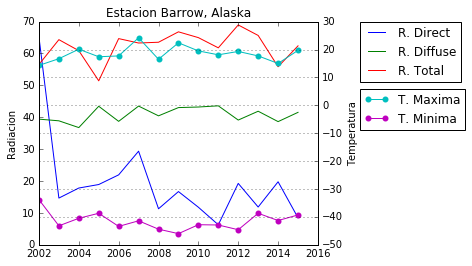

In [11]:
sub_df = df_agg[df_agg.station == 'brw']
sub_df = sub_df.reset_index()
sub_df = sub_df[sub_df.year >= 2002]
sub_max_temp = df_final_max[df_final_max["STATION"] == 'USW00027516']
sub_min_temp = df_final_min[df_final_min["STATION"] == 'USW00027516']
sub_max_temp = sub_max_temp[sub_max_temp.YEAR >= 2002]
sub_min_temp = sub_min_temp[sub_min_temp.YEAR >= 2002]


fig, ax1 = plt.subplots()
ax1.plot(sub_df.year,sub_df.direct,label = "R. Direct")
ax1.plot(sub_df.year,sub_df.diffuse, label = "R. Diffuse")
ax1.plot(sub_df.year,sub_df.total, label = "R. Total")
ax1.set_ylabel('Radiacion')

ax2 = ax1.twinx()
ax2.plot(sub_max_temp.YEAR,sub_max_temp.VALUE,  marker='.', color="c", mew=3, label="T. Maxima")
ax2.plot(sub_min_temp.YEAR,sub_min_temp.VALUE, marker='.', color="m", mew=3, label = "T. Minima")
ax2.set_ylabel('Temperatura')

plt.grid(True)
ax1.legend(bbox_to_anchor=(1.15, 1),loc=2,borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.15, 0.7),loc=2,borderaxespad=0.)
plt.title('Estacion Barrow, Alaska')
plt.show()


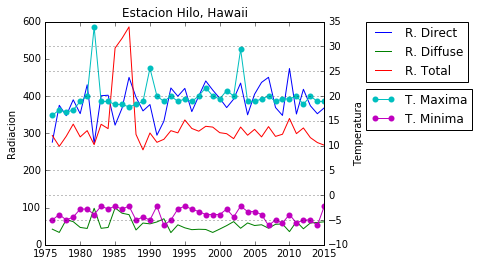

In [12]:
sub_df = df_agg[df_agg.station == 'mlo']
sub_df = sub_df.reset_index()
sub_df = sub_df[sub_df.year >= 1975]
sub_max_temp = df_final_max[df_final_max["STATION"] == 'USC00516198']
sub_min_temp = df_final_min[df_final_min["STATION"] == 'USC00516198']
sub_max_temp = sub_max_temp[sub_max_temp.YEAR >= 1975]
sub_min_temp = sub_min_temp[sub_min_temp.YEAR >= 1975]


fig, ax1 = plt.subplots()
ax1.plot(sub_df.year,sub_df.direct,label = "R. Direct")
ax1.plot(sub_df.year,sub_df.diffuse, label = "R. Diffuse")
ax1.plot(sub_df.year,sub_df.total, label = "R. Total")
ax1.set_ylabel('Radiacion')

ax2 = ax1.twinx()
ax2.plot(sub_max_temp.YEAR,sub_max_temp.VALUE,  marker='.', color="c", mew=3, label="T. Maxima")
ax2.plot(sub_min_temp.YEAR,sub_min_temp.VALUE, marker='.', color="m", mew=3, label = "T. Minima")
ax2.set_ylabel('Temperatura')

plt.grid(True)
ax1.legend(bbox_to_anchor=(1.15, 1),loc=2,borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.15, 0.7),loc=2,borderaxespad=0.)
plt.title('Estacion Hilo, Hawaii')
plt.show()

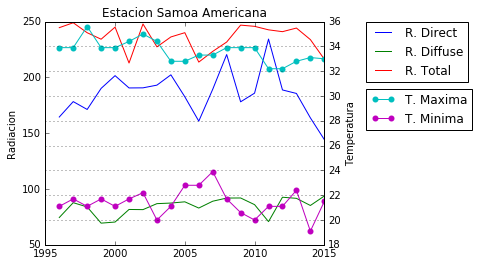

In [13]:
sub_df = df_agg[df_agg.station == 'smo']
sub_df = sub_df.reset_index()
sub_df = sub_df[sub_df.year >= 1996]
sub_max_temp = df_final_max[df_final_max["STATION"] == 'AQW00061705']
sub_min_temp = df_final_min[df_final_min["STATION"] == 'AQW00061705']
sub_max_temp = sub_max_temp[sub_max_temp.YEAR >= 1996]
sub_min_temp = sub_min_temp[sub_min_temp.YEAR >= 1996]


fig, ax1 = plt.subplots()
ax1.plot(sub_df.year,sub_df.direct,label = "R. Direct")
ax1.plot(sub_df.year,sub_df.diffuse, label = "R. Diffuse")
ax1.plot(sub_df.year,sub_df.total, label = "R. Total")
ax1.set_ylabel('Radiacion')

ax2 = ax1.twinx()
ax2.plot(sub_max_temp.YEAR,sub_max_temp.VALUE,  marker='.', color="c", mew=3, label="T. Maxima")
ax2.plot(sub_min_temp.YEAR,sub_min_temp.VALUE, marker='.', color="m", mew=3, label = "T. Minima")
ax2.set_ylabel('Temperatura')

plt.grid(True)
ax1.legend(bbox_to_anchor=(1.15, 1),loc=2,borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.15, 0.7),loc=2,borderaxespad=0.)
plt.title('Estacion Samoa Americana')
plt.show()

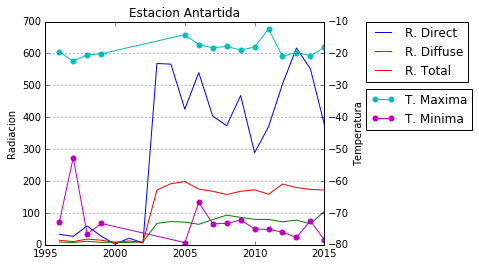

In [14]:
sub_df = df_agg[df_agg.station == 'spo']
sub_df = sub_df.reset_index()
sub_df = sub_df[sub_df.year >= 1996]
sub_max_temp = df_final_max[df_final_max["STATION"] == 'AYW00090001']
sub_min_temp = df_final_min[df_final_min["STATION"] == 'AYW00090001']
sub_max_temp = sub_max_temp[sub_max_temp.YEAR >= 1996]
sub_min_temp = sub_min_temp[sub_min_temp.YEAR >= 1996]


fig, ax1 = plt.subplots()
ax1.plot(sub_df.year,sub_df.direct,label = "R. Direct")
ax1.plot(sub_df.year,sub_df.diffuse, label = "R. Diffuse")
ax1.plot(sub_df.year,sub_df.total, label = "R. Total")
ax1.set_ylabel('Radiacion')

ax2 = ax1.twinx()
ax2.plot(sub_max_temp.YEAR,sub_max_temp.VALUE,  marker='.', color="c", mew=3, label="T. Maxima")
ax2.plot(sub_min_temp.YEAR,sub_min_temp.VALUE, marker='.', color="m", mew=3, label = "T. Minima")
ax2.set_ylabel('Temperatura')

plt.grid(True)
ax1.legend(bbox_to_anchor=(1.15, 1),loc=2,borderaxespad=0.)
ax2.legend(bbox_to_anchor=(1.15, 0.7),loc=2,borderaxespad=0.)
plt.title('Estacion Antartida')
plt.show()